In [1]:
import numpy as np
import tensorflow as tf
import afqstensorutils as atu
from matplotlib import pylab as plt

In [2]:
@tf.RegisterGradient('TruncateMod')
def grad_truncate_mod(unused_op, grad):
    return grad, tf.constant(1)

A simple example is the pendulum,
\begin{align}
\text{Solve for}\, x(t), \, y(t), \, f(t) \, \text{satisfying:} \\
m \dot{x} & = f x/L \\
m \dot{y} & = f y/L + m g \\
x^2 + y^2 & = L^2
\end{align}
In our methodology, we do not have an explicit equation for the constraint, but a dataset of (x,y) pairs that are on the manifold. For our proof-of-concept test, we manufacture this data for the pendulum.

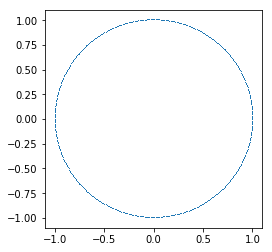

In [3]:
theta = np.linspace(0,2.0*np.pi,500, dtype=np.float32)
data = np.vstack([np.cos(theta), np.sin(theta)]).T
plt.plot(data[:,0],data[:,1],',')
plt.axis('square')
dataset = tf.data.Dataset.from_tensor_slices(data)

Yup, that's a circle. Can we find an autoencoder for this circle?

In [34]:
graph = tf.Graph()
tf.set_random_seed(1234) # Make this notebook deterministic for debugging
with graph.as_default():
    # Input variables of the network
    repeat_dataset = dataset.repeat()
    shuffled_dataset = repeat_dataset.shuffle(buffer_size=1000)
    batched_dataset = shuffled_dataset.batch(100)
    iterator = batched_dataset.make_one_shot_iterator()
    next_element = iterator.get_next()
    tr_x = tf.stack(next_element)
    
    #
    # The parameters
    N_poly_en = 5
    N_poly_de = 5
    N_poly_coeff_en = atu.Npolyexpand(2,N_poly_en)
    N_poly_coeff_de = atu.Npolyexpand(1,N_poly_de)
    p_V, (We1,be1, Wd1,bd1) = atu.CatVariable(
        [ (N_poly_coeff_en,1), (1,),
          (N_poly_coeff_de,2), (2,) ],
        stddev=2.0)
    # Encoding phase
    # The latent variable
    def encode(x):
        u = tf.matmul( atu.polyexpand(x,N_poly_en), We1) + be1
        u_loop = tf.sin(u)#tf.truncatemod(u,1.0)
        return u_loop
    
    def decode(u):
        return tf.matmul( atu.polyexpand(u,N_poly_de),Wd1) + bd1

    tr_u = encode(tr_x)
    tr_xd = decode(tr_u)
    
    # The error is how close they are
    goal_auto = tf.reduce_sum(tf.pow(tr_xd - tr_x,2))
    # We also want the latent space to be contractive:
    grad_xd = tf.gradients(tr_xd,tr_u)[0]
    grad_u = tf.gradients(tr_u,tr_x)[0]
    goal_contract = 0.0*tf.reduce_sum(tf.pow(grad_xd,2)) \
        + 0.1*tf.reduce_sum(tf.pow(grad_u,2))
    goal = goal_auto + goal_contract
    train_step = tf.train.AdamOptimizer(1e-2).minimize(goal, var_list=[p_V])
    #train_step = atu.NewtonsMethod(goal,p_V, alpha=1.0e-4)
    init=tf.global_variables_initializer()
    
    
    i_x = tf.placeholder(tf.float32, shape=(None,2),name='x')
    o_u = encode( i_x )
    # We also want to investigate it
    i_u = tf.placeholder(tf.float32, shape=(None,1),name='u')
    o_xd = decode(i_u)

In [35]:
try:
    sess.close()
except:
    pass
sess = tf.InteractiveSession(graph=graph)
init.run(session=sess)

In [63]:
for i in xrange(1000):
    #train_step.run(session=sess)
    sess.run(train_step)
    if i%100==99:
        print goal.eval(session=sess)

45.827118
45.094994
30.78396
37.552536
35.301273
33.85101
48.836853
28.629347
42.16587
38.3284


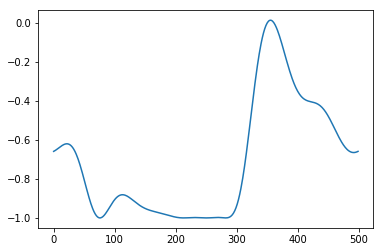

In [64]:
u_enc = o_u.eval(feed_dict={i_x:data})
plt.plot(u_enc)

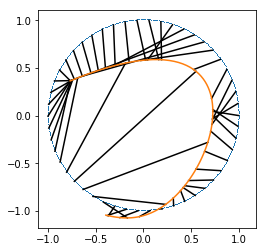

In [65]:
xy_dec = o_xd.eval(feed_dict={i_u:u_enc.reshape(-1,1)})
plt.plot(data[:,0],data[:,1],',')
for a,b in zip(xy_dec,data)[::10]:
    plt.plot( [a[0],b[0]], [a[1],b[1]],'-k')
xy_dec = o_xd.eval(feed_dict={i_u:np.linspace(u_enc.min(),u_enc.max(),100).reshape(-1,1)})
plt.plot(xy_dec[:,0],xy_dec[:,1],'-')
plt.axis('square');

What's the problem? The topology of the constraint manifold is not a plane! When we do the nonlinear mapping to the latent space, we are still in a domain of $-\infty$ to $\infty$. With our prior knowledge, we know the latent space has a loop to it. 

The topological insight (prior knowledge) is that the circular constraint manifold requires two charts [https://en.wikipedia.org/wiki/Atlas_(topology)](https://en.wikipedia.org/wiki/Atlas_(topology)). This translates to having two latent spaces (one for each chart) and then combining them in the decoding phase. There would need to be some other classifier for telling us which chart we are on, which go through a transition map as the coordinates on the two charts are decoded.

We're not interested in problems with nonplanar. 